Обучить СНС с помощью Transfer Learning на датасете Food-101

Использовать тонкую настройку существующей предобученной модели и методы аугментации данных.

Библиотеки: [Python, Tensorflow]

In [2]:
import tensorflow as tf

gpu_device = tf.config.experimental.list_physical_devices('GPU')
if gpu_device:
    tf.config.experimental.set_memory_growth(gpu_device[0], True)

In [2]:
# !pip install tensorflow_datasets

In [3]:
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf
import tensorflow_datasets as tfds

### Загрузка данных.

In [4]:
(train_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:90%]', 'train[90%:]'], 
    data_dir='./food101', 
)

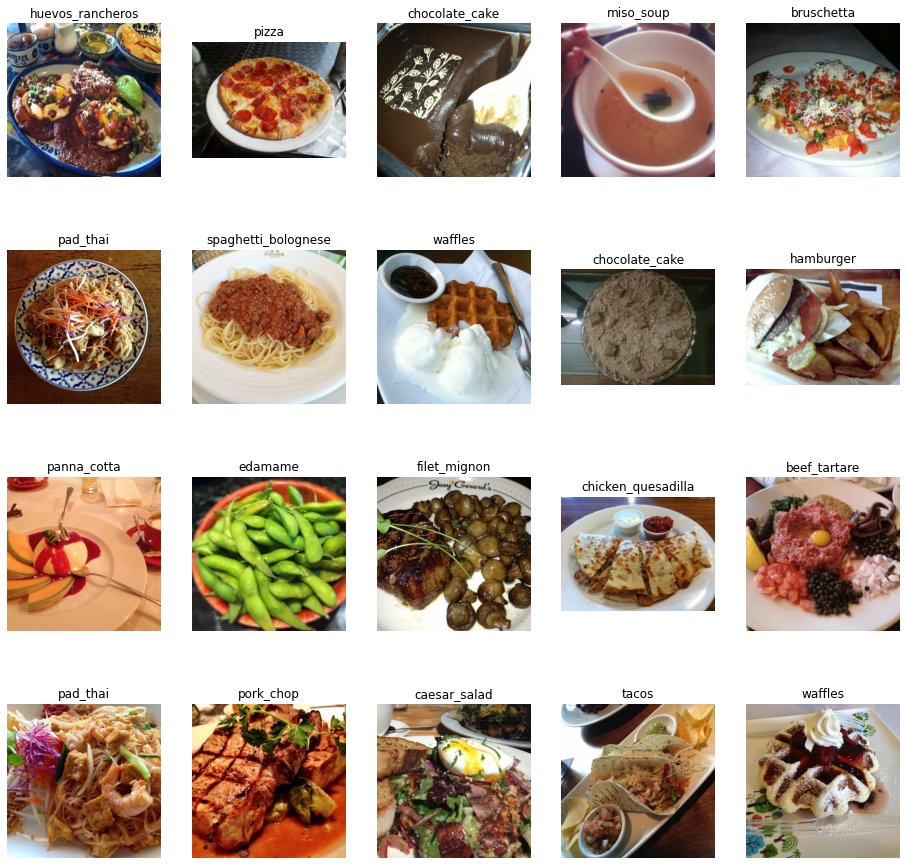

In [5]:
shape = (4, 5)
width = 16

fig, ax = plt.subplots(*shape, figsize=(width, shape[0] * (width//shape[1] + 1)))

for i, (img, label) in enumerate(iter(train_ds.take(np.prod(shape)))):
    pos = ax[i//shape[1], i%shape[1]]
    pos.imshow(img)
    pos.set_title(ds_info.features['label'].int2str(label))
    pos.axis('off')
plt.show()

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

### Подготовка данных.

Аугментация данных. Будут осуществлены случайные преобразования изображений из обучающего набора в процессе обучения, такие как поворот, сдвиг, увеличение/уменьшение. При помощи данного трюка мы будем бороться с переобучением.

In [7]:
INP_SIZE = 224

resize_and_rescale = Sequential([
    layers.Resizing(INP_SIZE, INP_SIZE),
    layers.Rescaling(scale=1./127.5, offset=-1)
])

data_augmentation = Sequential([
    layers.RandomFlip("horizontal_and_vertical"), 
    layers.RandomTranslation(height_factor=(-0.1, 0.1), width_factor=(-0.1, 0.1), fill_mode='nearest'), 
    layers.RandomRotation(0.2, fill_mode='reflect'), 
    layers.RandomZoom(height_factor=(-0.2, 0.2), width_factor=None, fill_mode='reflect'), 
])

In [8]:
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

def prepare(ds, shuffle=False, augment=False):
    ds = ds.map(lambda x, y: (resize_and_rescale(x), y), 
              num_parallel_calls=AUTOTUNE)

    if shuffle:
        ds = ds.shuffle(1000)

    ds = ds.batch(BATCH_SIZE)

    if augment:
        ds = ds.map(lambda x, y: (data_augmentation(x, training=True), y), 
                    num_parallel_calls=AUTOTUNE)

    return ds.prefetch(buffer_size=AUTOTUNE)

Датасет разделим на 3 части: train, valid и test. На test будем проверять модель после обучения.

In [10]:
(train_ds, val_ds, test_ds), ds_info = tfds.load(
    'food101', 
    as_supervised=True,
    with_info=True,
    split=['train[:80%]', 'train[80%:90%]', 'train[90%:]'], 
    data_dir='./food101', 
)

In [11]:
train_ds = prepare(train_ds, shuffle=True, augment=True)
val_ds = prepare(val_ds)
test_ds = prepare(test_ds)

Визуализация преобразованных изображений.

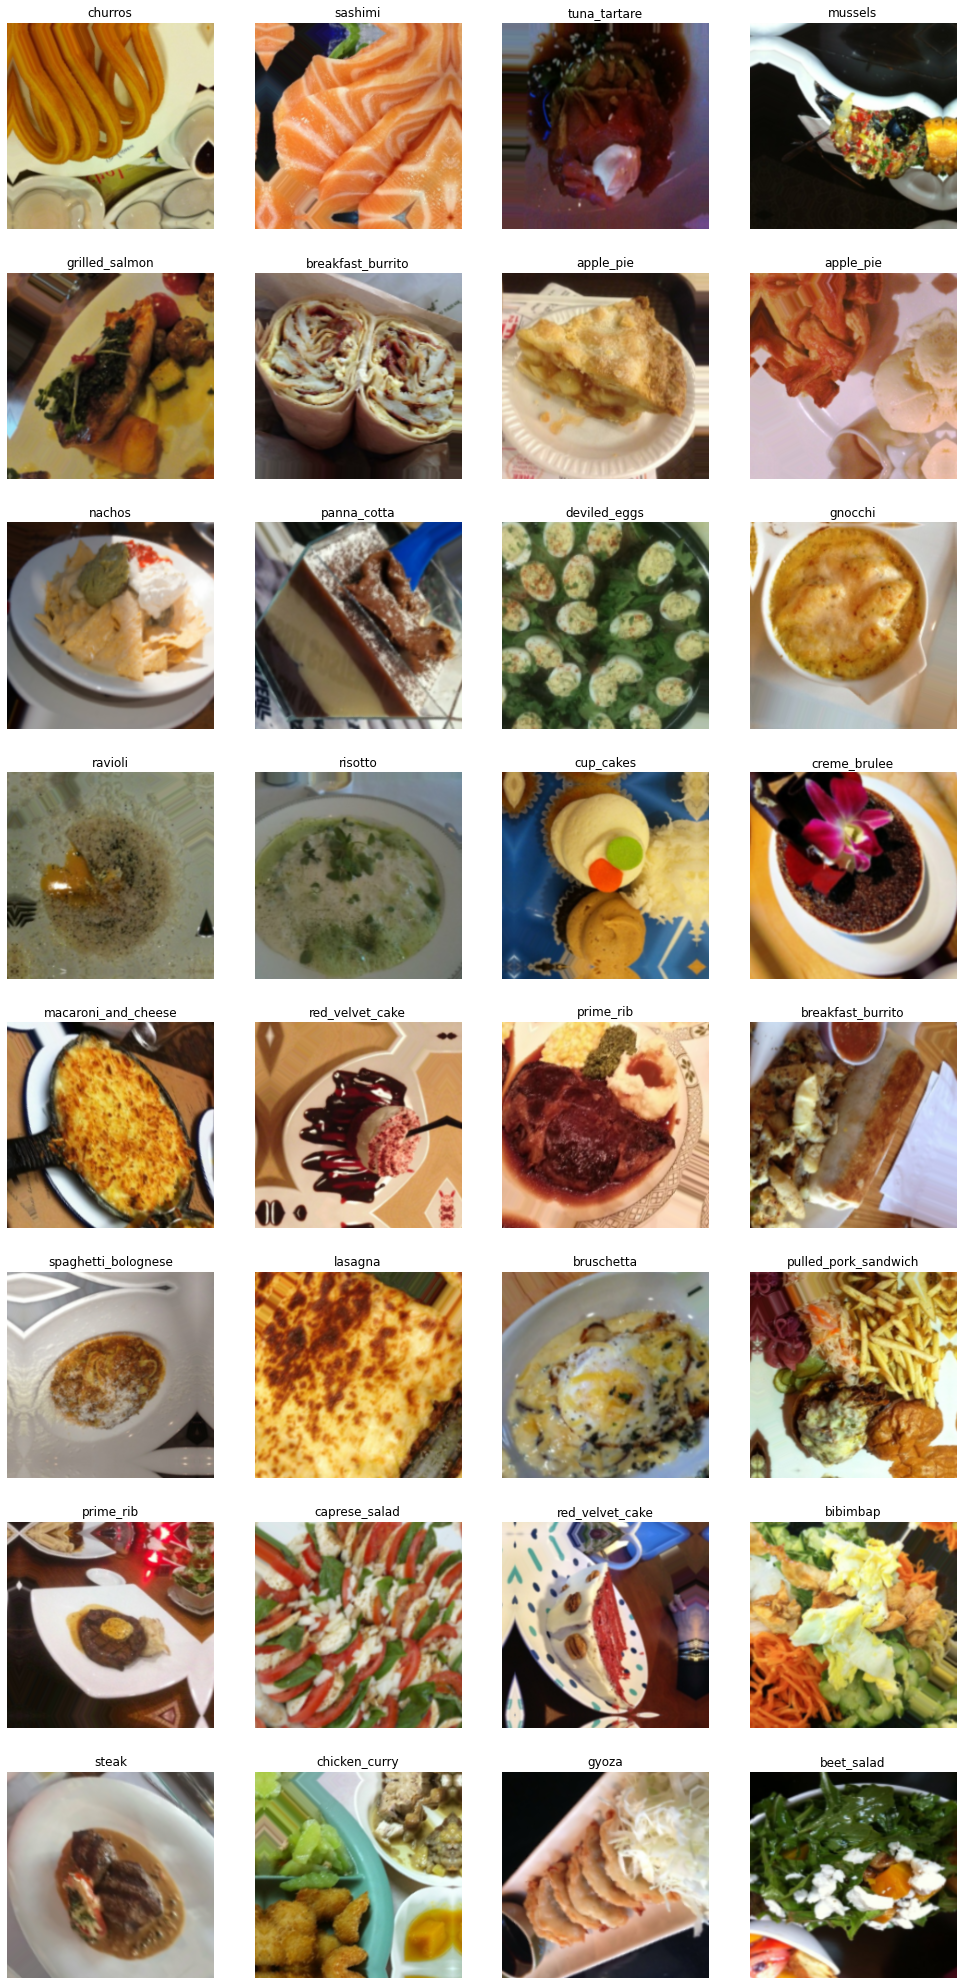

In [12]:
images, labels = next(iter(train_ds.take(1)))

fig, ax = plt.subplots(8, 4, figsize=(17, 36))

for i, img in enumerate(images):
    pos = ax[i//4, i%4]
    img = np.clip((img + 1) / 2, 0, 1)
    pos.imshow(img)
    pos.set_title(ds_info.features['label'].int2str(labels[i]))
    pos.axis('off')

### Подготовка модели.

Будем использовать сверточную основу сети MobileNetV2. Веса возьмем от предобученной модели на датасете ImageNet.

In [19]:
base_model = tf.keras.applications.MobileNetV2(
        input_shape=(INP_SIZE, INP_SIZE, 3),
        include_top=False,
        weights='imagenet',
    )

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 112, 112, 32) 0           bn_Conv1[0][0]                   
_______________________________________________________________________________

Заморозим слои у первых 5 блоков у сверточной основы. Не имеет смысла сетку обучать полностью, т.к. начальные слои сверточной основы кодируют более обобщенные признаки, такие как присутствие на изображении очертаний каких-либо форм. Слои дальше кодируют уже более сложные признаки. 

Набор данных imagenet содержит в себе изображения около 1000 классов, а среди них в основном различные виды животных, техника и пр. Также присутствует небольшое количество блюд (пицца, паста и пр.), но их видов значительно меньше, чем в нашем датасете. Поэтому имеет смысл дообучать все слои, кроме начальных.

In [20]:
base_model.trainable = True

for layer in base_model.layers:
    if 'block_6' in layer.name:
        break
    layer.trainable = False

К сверточной основе добавим полносвязные слои.

In [21]:
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1024), 
    layers.Dropout(0.3),
    layers.Activation('relu'), 
    layers.Dense(512), 
    layers.Dropout(0.3),
    layers.Activation('relu'), 
    layers.Dense(101, activation='softmax'),
])

model.summary()

model.compile(loss='sparse_categorical_crossentropy',
              optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1280)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              1311744   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
activation_2 (Activation)    (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

### Обучение модели.

В процессе обучения будем менять learning rate, согласно следующей функции:

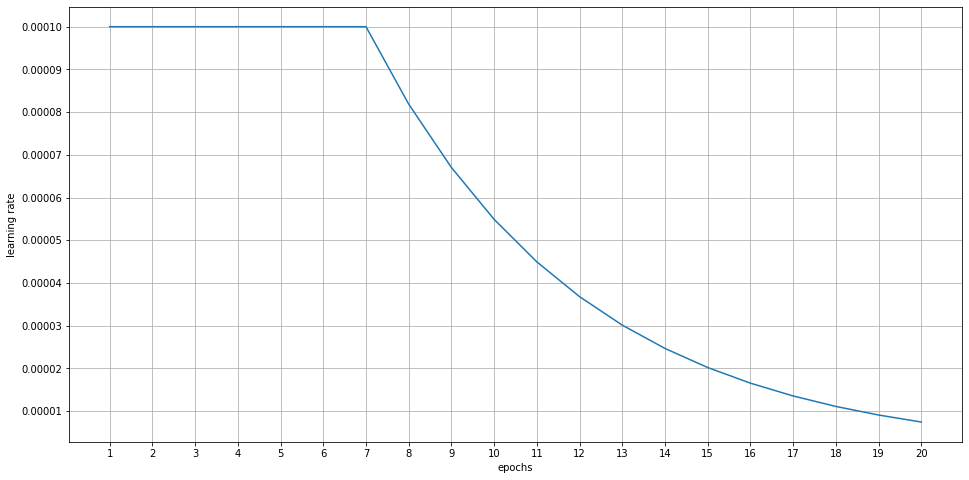

In [22]:
dots = list(range(1, 21))

def f(x):
    lr = 1e-4
    out = []
    for i in x:
        if i <= 7:
            out.append(lr)
        else:
            out.append(lr * np.exp(0.2 * (7 - i)))
    return out


plt.figure(figsize=(16, 8))
plt.plot(dots, f(dots))
plt.grid()
plt.xticks(dots)
plt.yticks(np.linspace(1e-5, 1e-4, 10))
plt.xlabel('epochs')
plt.ylabel('learning rate')
plt.show()

Callbacks.

In [23]:
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping


def scheduler(epoch):
    lr = 1e-4
    if epoch <= 7:
        return lr
    else:
        return lr * tf.math.exp(0.2 * (7 - epoch))


lr_scheduler = LearningRateScheduler(
                                    schedule=scheduler, 
                                    verbose=1
)

early_stopping = EarlyStopping(
                            monitor='val_loss', 
                            patience=3, 
                            verbose=1,
                            mode='auto', 
                            restore_best_weights=True
)

In [24]:
history = model.fit(train_ds, 
                    epochs=20, 
                    validation_data=val_ds, 
                    callbacks=[lr_scheduler, early_stopping]
                    )

Epoch 1/20

Epoch 00001: LearningRateScheduler setting learning rate to 0.0001.
1894/1894 [==============================] - 269s 139ms/step - loss: 3.0219 - accuracy: 0.2963 - val_loss: 2.6397 - val_accuracy: 0.3917
Epoch 2/20

Epoch 00002: LearningRateScheduler setting learning rate to 0.0001.
1894/1894 [==============================] - 293s 154ms/step - loss: 2.0311 - accuracy: 0.4929 - val_loss: 2.0268 - val_accuracy: 0.5184
Epoch 3/20

Epoch 00003: LearningRateScheduler setting learning rate to 0.0001.
1894/1894 [==============================] - 291s 153ms/step - loss: 1.7467 - accuracy: 0.5557 - val_loss: 1.7677 - val_accuracy: 0.5514
Epoch 4/20

Epoch 00004: LearningRateScheduler setting learning rate to 0.0001.
1894/1894 [==============================] - 306s 161ms/step - loss: 1.5870 - accuracy: 0.5939 - val_loss: 1.6854 - val_accuracy: 0.5881
Epoch 5/20

Epoch 00005: LearningRateScheduler setting learning rate to 0.0001.
1894/1894 [==============================] - 284s 15

### Проверка качества классификации на тестовом наборе.

In [25]:
model.evaluate(test_ds)

237/237 [==============================] - 18s 77ms/step - loss: 1.2389 - accuracy: 0.7009


[1.2388875484466553, 0.7008580565452576]